In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import math 
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [3]:
print(dataset)

{'test': <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>, 'train': <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>}


In [4]:
print(metadata)

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

In [5]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [6]:
print(train_dataset), print(test_dataset)

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>


(None, None)

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

In [8]:
metadata.features['image'].shape, metadata.features['label'].shape

((28, 28, 1), ())

In [10]:
# 数据预处理 【1、归一化；2、将数据转化为tensor】
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

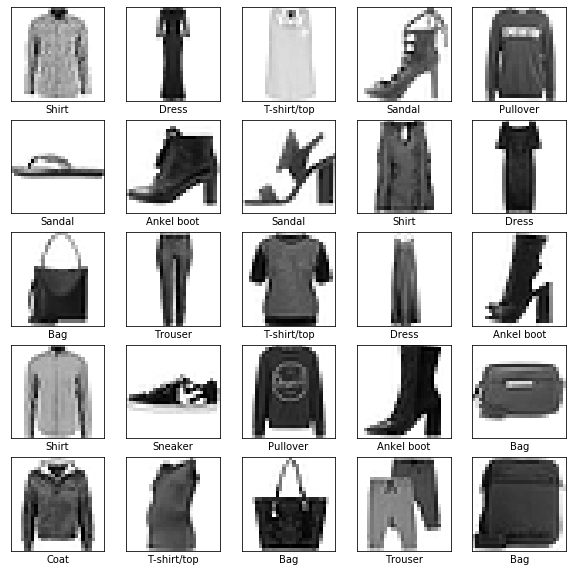

In [12]:
# 数据可视化
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [13]:
# 建立模型 【序惯型】
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 建立模型 【函数式】
inputs = tf.keras.Input(shape=(28,28,1))
flatten = tf.keras.layers.Flatten()(inputs)
hidden = tf.keras.layers.Dense(128, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(10, activation='softmax')(hidden)
model = tf.keras.models.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
batch_size = 32
num_train_example = metadata.splits['train'].num_examples
num_test_example = metadata.splits['test'].num_examples
print(num_train_example)
print(num_test_example)

60000
10000


In [25]:
train_dataset = train_dataset.repeat().shuffle(num_train_example).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [26]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_example/batch_size))

Train for 1875 steps
Epoch 1/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.4947 - accuracy: 0.8256
Epoch 2/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.3732 - accuracy: 0.8649
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.3350 - accuracy: 0.8776
Epoch 4/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.3109 - accuracy: 0.8850
Epoch 5/5
1875/1875 [==============================] - 19s 10ms/step - loss: 0.2915 - accuracy: 0.8928


In [27]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_example/batch_size))

313/313 [==============================] - 3s 9ms/step - loss: 0.3491 - accuracy: 0.8717


In [28]:
for test_image, test_label in test_dataset.take(1):
    test_image = test_image.numpy()
    test_label = test_label.numpy()
    predictions = model.predict(test_image)

In [29]:
# 结果可视化
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[...,0], cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% ({class_names[true_label]})',
               color=color)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='#777777')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

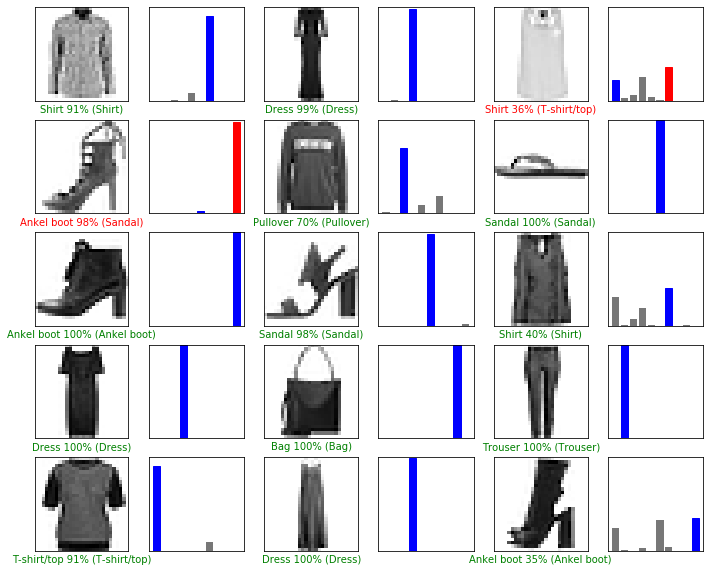

In [30]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_label, test_image)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_label)